In [30]:
!export CUDA_VISIBLE_DEVICES=0

In [31]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value


In [32]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers.utils import load_image
from diffusers import DDIMScheduler

In [33]:
device="cuda"
pipe=StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
print(pipe)

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.18.2",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



In [34]:
# read image
image_path="/root/autodl-tmp/lijia/images/02.png"
image=load_image(image_path)
# image_feature=torch.tensor(pipe.feature_extractor(image,device=device)["pixel_values"]).to(device)
# print(image_feature.size())
# image_feature=pipe.vae.encode(image_feature)
# image
image_feature= pipe.image_processor.preprocess(image).to(device)
print(image_feature)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')


In [35]:
width=height=512
bz=1

# random
seed=42
torch.manual_seed(seed)

In [36]:
print(torch.cuda.is_available())
prompt="a photo of a cat"
prompt_embeddings=pipe._encode_prompt(prompt,device,1,True)
prompt_embeddings

True


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 1.1565,  0.1318,  0.7895,  ..., -2.1024, -1.1519, -0.3311],
         ...,
         [-0.6092, -0.3139,  0.1654,  ..., -0.0817,  0.1914, -0.6629],
         [-0.6012, -0.3219,  0.1768,  ..., -0.0749,  0.1929, -0.6510],
         [-0.6359, -0.2540,  0.2309,  ..., -0.0837,  0.2615, -0.6855]]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [37]:
num_inference_steps=50
# set timesteps
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps, num_inference_steps = pipe.get_timesteps(num_inference_steps, 0.8, device)
latent_timestep = timesteps[:1].repeat(bz * 1)

In [38]:
# Prepare latent variables
latents = pipe.prepare_latents(
    image_feature, latent_timestep, bz, 1, prompt_embeddings.dtype, device)

In [39]:
do_classifier_free_guidance=7.5


num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
with pipe.progress_bar(total=num_inference_steps) as progress_bar:
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        with torch.no_grad():
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeddings.to(device),
                return_dict=False,
            )[0]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + do_classifier_free_guidance * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

  0%|          | 0/40 [00:00<?, ?it/s]

In [40]:
image_new = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]

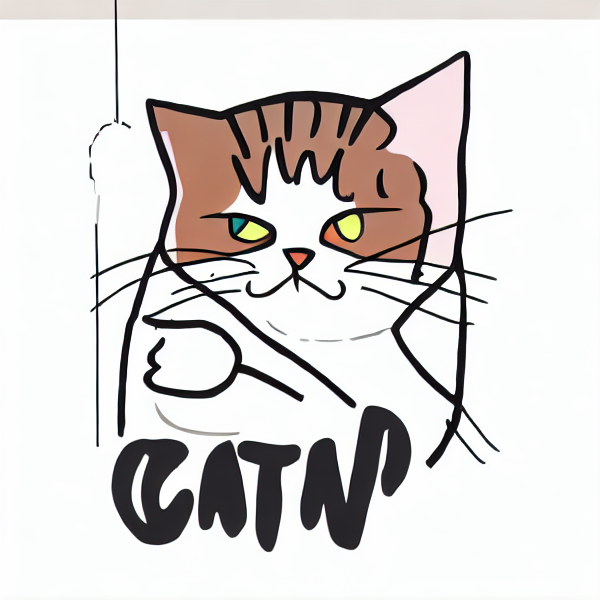

In [41]:
result=pipe.image_processor.postprocess(image_new.detach())
result[0]

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])


  0%|          | 0/40 [00:00<?, ?it/s]

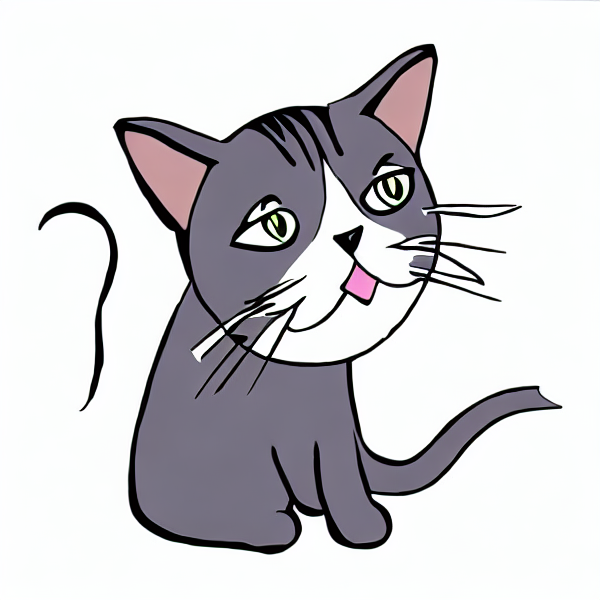

In [42]:
pipe(prompt="a photo of a cat", image=image).images[0]